## Cuidado! Lluvia de Hamburguesas: 
## Análisis con Redes Neuronales


## Integrantes
* Primerano Lomba, Franco Alejandro
* Montecalvo, Ignacio

## Configuraciones iniciales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import seed
seed(119)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import tensorflow as tf
tf.random.set_seed(119)

from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

from auxiliares import obtener_training_set
from auxiliares import obtener_valdev_set
from auxiliares import obtener_prediccion_set
from auxiliares import crear_archivo_predicciones
from auxiliares import plot_confusion_matrix
from auxiliares import plot_roc
from auxiliares import graficarHistoriaDeLaRed
from preprocessing import manejo_missing_values
from preprocessing import aplicarOneHot
from preprocessing import aplicarPCA
from preprocessing import normalizar_entre_0_y_1
from preprocessing import normalizar_segun_maximo_valor_absoluto

2021-12-24 15:48:42.399820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-24 15:48:42.399839: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Primero cargamos los datos y hacemos la división del dataset quedándonos con un 10% de los datos para el hold out:

In [2]:
x,y = obtener_training_set()
x_val,y_val = obtener_valdev_set()

## Redes neuronales

Las redes neuronales son conjuntos de neuronas unidas que asignan un peso y bias a las entradas y devuelven un resultado.

Los hiperparametros a buscar son:

* Función de perdida: Es la función utilizada por el optimizador para minimizar. En este caso al ser una clasificación binaria utilizaremos binary cross entropy.
* Optimizador: Es el algoritmo que, mediante la función de perdida, optimiza el resultado final. Utilizaremos Stochastic Gradient Descent(SGD) y Adam.
* Tasa de aprendizaje: Es el hiperparametro que define que tanto se modifican los valores al intentar minimizar. A valores más bajos, mas lenta es la minimización pero a valores altos podría nunca llegar a un minimo local.
* Cantidad de epochs: Es la cantidad de iteraciones que tendrá el entrenamiento.
* Función de activación: Provaremos con sigmoidea y relu.
* Cantidad de capas: Es la cantidad de capas que tendrá la red neuronal. Seleccionaremos manualmente una capa input, 2 ocultas y 1 de salida.
* Cantidad de neuronas por capa: La primer capa tendrá 7 neuronas pues mediante PCA reduciremos el dataset a 7 features. La última tendrá 1 sola que nos indicará a que clase pertenece.

## Preprocesamiento

### One Hot Encoding
En primer lugar aplicamos One-hot encoding para las variables categóricas:

In [3]:
x = aplicarOneHot(x)
x_val = aplicarOneHot(x_val)

### Reducción de dimensionalidad
Como en el caso de algunos modelos anteriores creemos que es buena idea obtener las componentes principales que expliquen una cantidad alta de varianza. Sabemos que con 7 logramos explicar el 95% de la varianza.


In [4]:
pca, componentes_principales = aplicarPCA(x.copy(), x.copy(), 7)
pca_val, componentes_principales_val = aplicarPCA(x, x_val, 7)

### Normalización

Una vez aplicada la reducción de dimensionalidad, procedemos a normalizar nuestros datos con dos preprocesamientos distintos, uno de manera tal que los valores posibles para cada uno de los features esté entre 0 y 1. El otro utilizando el máximo valor absoluto.

In [5]:
x_normalizado_abs = normalizar_segun_maximo_valor_absoluto(componentes_principales.copy(), componentes_principales.copy())
x_normalizado = normalizar_entre_0_y_1(componentes_principales.copy(), componentes_principales.copy())
y_to_validate = y['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0})
y_to_validate_valdev = y_val['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0})

In [6]:
x_val_normalizado = normalizar_entre_0_y_1(componentes_principales.copy(), componentes_principales_val.copy())
x_val_normalizado_abs = normalizar_segun_maximo_valor_absoluto(componentes_principales.copy(), componentes_principales_val)

## Entrenando las redes

Empezaremos entrenando una red con función de activación relu. (Siempre la última capa debe tener activación sigmoidea). Y con el primer preprocesamiento.

In [7]:
red1 = Sequential()
red1.add(Dense(7, input_dim=7, activation='relu'))
red1.add(Dense(6, activation='relu'))
red1.add(Dense(3, activation='relu'))
red1.add(Dense(1, activation='sigmoid'))
red1.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

2021-12-24 14:15:37.792269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 14:15:37.792292: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 14:15:37.792309: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-Latitude-5520): /proc/driver/nvidia/version does not exist
2021-12-24 14:15:37.792505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
red1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 6)                 48        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [9]:
red1.fit(x_normalizado, y_to_validate, epochs=1800, batch_size=100, verbose=0, validation_split=0.25)

## Veamos su desempeño mediante su AUC score.

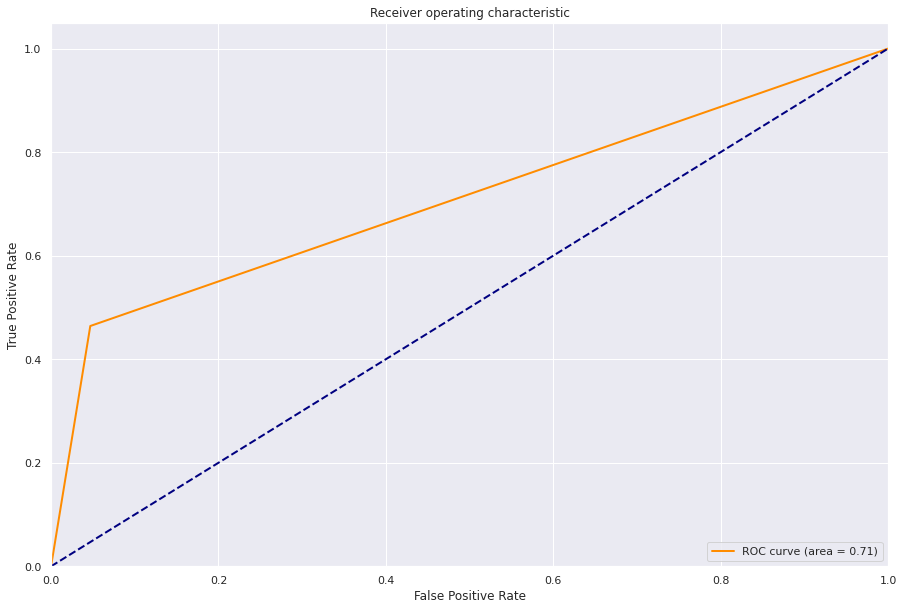

0.7086545806742077

In [10]:
fpr, tpr, thresholds = roc_curve(y_to_validate_valdev, red1.predict(x_val_normalizado).round())
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_to_validate_valdev, red1.predict(x_val_normalizado).round()))

No es tan buen puntaje, obtuvimos mucho mejores AUC-Scores con otros modelos.

Ahora probemos la misma red con el otro preprocesamiento.

In [7]:
red2 = Sequential()
red2.add(Dense(7, input_dim=7, activation='relu'))
red2.add(Dense(6, activation='relu'))
red2.add(Dense(3, activation='relu'))
red2.add(Dense(1, activation='sigmoid'))
red2.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

2021-12-24 14:33:03.067752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 14:33:03.067768: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 14:33:03.067780: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-Latitude-5520): /proc/driver/nvidia/version does not exist
2021-12-24 14:33:03.067934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
red2.fit(x_normalizado_abs, y_to_validate, epochs=1800, batch_size=100, verbose=0, validation_split=0.25)

## Veamos su desempeño mediante su AUC score.

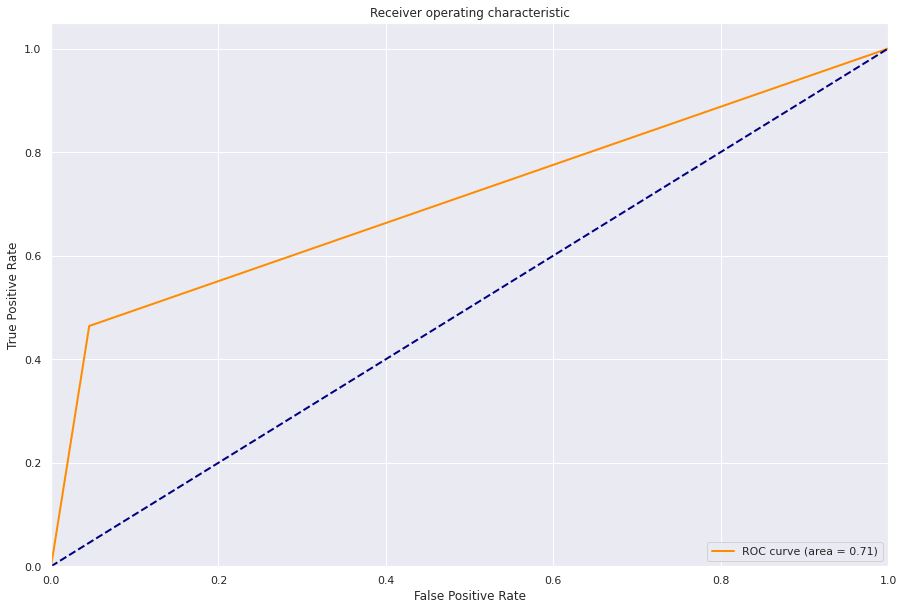

0.7092889546829982

In [9]:
fpr, tpr, thresholds = roc_curve(y_to_validate_valdev, red2.predict(x_val_normalizado_abs).round())
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_to_validate_valdev, red2.predict(x_val_normalizado_abs).round()))

Levemente superior al de la anterior red.

Ahora probemos cambiando todas las capas por sigmoideas. Empezaremos por el primer preprocesado.

In [7]:
red3 = Sequential()
red3.add(Dense(7, input_dim=7, activation='sigmoid'))
red3.add(Dense(6, activation='sigmoid'))
red3.add(Dense(3, activation='sigmoid'))
red3.add(Dense(1, activation='sigmoid'))
red3.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

2021-12-24 14:46:50.724287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 14:46:50.724310: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 14:46:50.724323: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-Latitude-5520): /proc/driver/nvidia/version does not exist
2021-12-24 14:46:50.724470: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
red3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 6)                 48        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [9]:
red3.fit(x_normalizado, y_to_validate, epochs=1800, batch_size=100, verbose=0, validation_split=0.25)

## Veamos su desempeño mediante su AUC score.

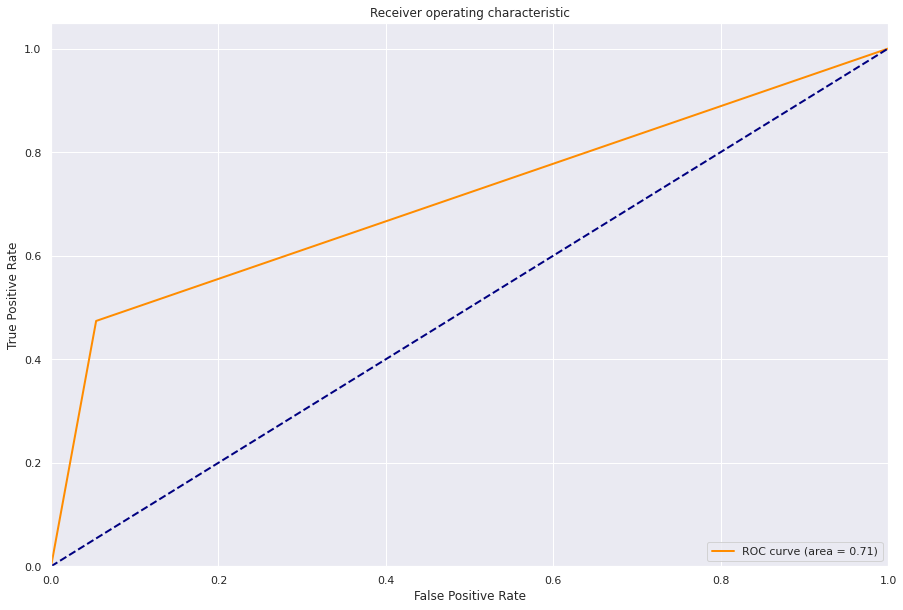

0.7100382051725427

In [10]:
fpr, tpr, thresholds = roc_curve(y_to_validate_valdev, red3.predict(x_val_normalizado).round())
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_to_validate_valdev, red3.predict(x_val_normalizado).round()))

Levemente superior a la red anterior. Probemos con el otro preprocesamiento.

In [7]:
red4 = Sequential()
red4.add(Dense(7, input_dim=7, activation='sigmoid'))
red4.add(Dense(6, activation='sigmoid'))
red4.add(Dense(3, activation='sigmoid'))
red4.add(Dense(1, activation='sigmoid'))
red4.compile(loss='binary_crossentropy', optimizer="SGD", metrics=[tf.keras.metrics.AUC()])

2021-12-24 14:58:29.763369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 14:58:29.763392: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 14:58:29.763406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-Latitude-5520): /proc/driver/nvidia/version does not exist
2021-12-24 14:58:29.763564: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
red4.fit(x_normalizado_abs, y_to_validate, epochs=1800, batch_size=100, verbose=0, validation_split=0.25)

## Veamos su desempeño mediante su AUC score.

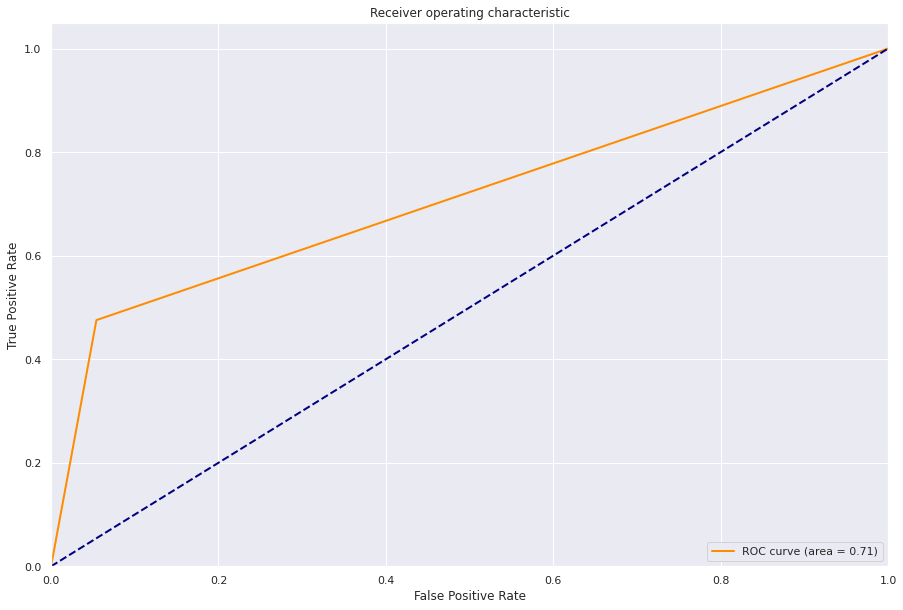

0.7106655280488423

In [9]:
fpr, tpr, thresholds = roc_curve(y_to_validate_valdev, red4.predict(x_val_normalizado_abs).round())
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_to_validate_valdev, red4.predict(x_val_normalizado_abs).round()))

Vemos que con este preprocesamiento obtenemos un resultados decimalmente superior que con el primero. A partir de aquí utilizaremos el segundo preprocesamiento(normalización según valor absoluto). 
### Veremos si con otro optimizador logramos mejorar su performance.

In [7]:
red5 = Sequential()
red5.add(Dense(7, input_dim=7, activation='sigmoid'))
red5.add(Dense(6, activation='sigmoid'))
red5.add(Dense(3, activation='sigmoid'))
red5.add(Dense(1, activation='sigmoid'))
red5.compile(loss='binary_crossentropy', optimizer="Adam", metrics=[tf.keras.metrics.AUC()])

2021-12-24 15:49:00.707521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 15:49:00.707551: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 15:49:00.707574: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-Latitude-5520): /proc/driver/nvidia/version does not exist
2021-12-24 15:49:00.707849: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
red5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 56        
                                                                 
 dense_1 (Dense)             (None, 6)                 48        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [9]:
red5.fit(x_normalizado_abs, y_to_validate, epochs=1800, batch_size=100, verbose=0, validation_split=0.25)

## Veamos su desempeño mediante su AUC score

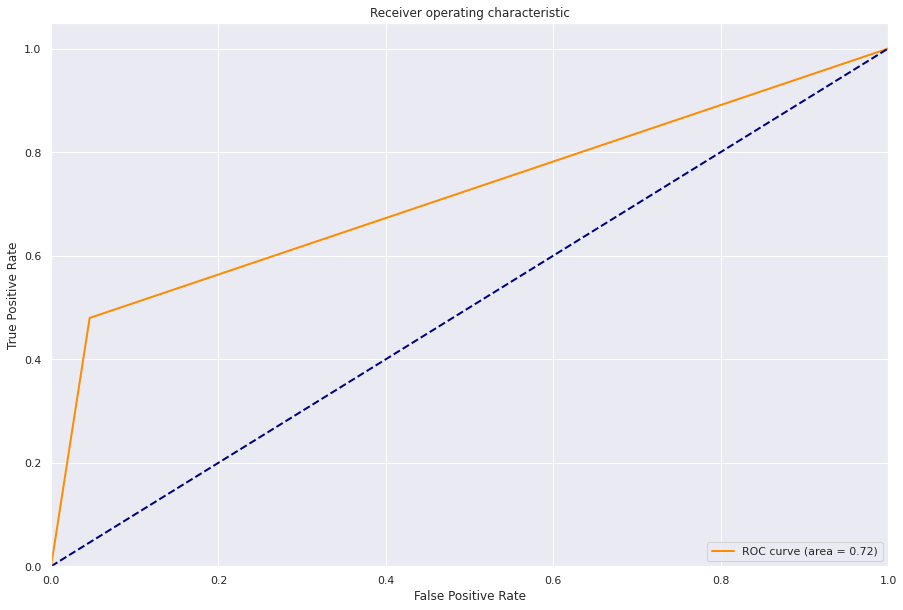

0.7168203084695255

In [10]:
fpr, tpr, thresholds = roc_curve(y_to_validate_valdev, red5.predict(x_val_normalizado_abs).round())
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_to_validate_valdev, red5.predict(x_val_normalizado_abs).round()))

Obtuvimos un puntaje levemente superior al optimizador SGD, así que nos quedaremos con Adam.

## Regularizando la red

Como obtuvimos un AUC score un poco superior con la red cuyas capas tenian la función de activación sigmoidea, con el preprocesamiento de estandarizado según el máximo valor absoluto, y como optimizador Adam. Seguiremos con todo esto y ahora aplicaremos técnicas de regularización. Empezaremos aplicando una capa de dropout

In [7]:
red6 = Sequential()
red6.add(Dense(7, input_dim=7, activation='sigmoid'))
red6.add(Dropout(0.1))
red6.add(Dense(6, activation='sigmoid'))
red6.add(Dropout(0.1))
red6.add(Dense(3, activation='sigmoid'))
red6.add(Dense(1, activation='sigmoid'))
red6.compile(loss='binary_crossentropy', optimizer="Adam", metrics=[tf.keras.metrics.AUC()])

2021-12-24 15:23:28.924623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 15:23:28.924640: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 15:23:28.924651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-Latitude-5520): /proc/driver/nvidia/version does not exist
2021-12-24 15:23:28.924794: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
red6.fit(x_normalizado_abs, y_to_validate, epochs=1800, batch_size=100, verbose=0, validation_split=0.25)

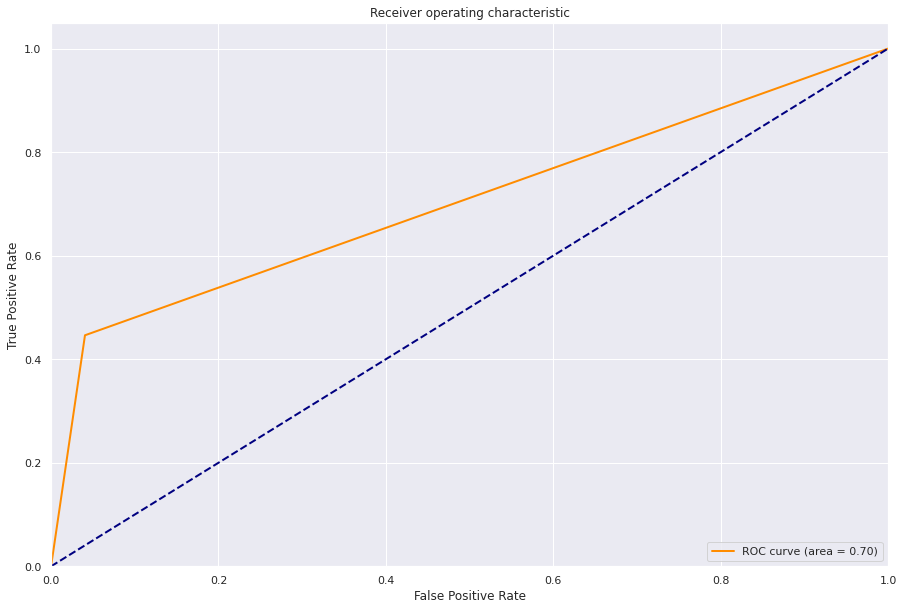

0.702867004003291

In [9]:
fpr, tpr, thresholds = roc_curve(y_to_validate_valdev, red6.predict(x_val_normalizado_abs).round())
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_to_validate_valdev, red6.predict(x_val_normalizado_abs).round()))

Observamos que con dropout no logramos mejorar el AUC Score sino por el contrario empeorarlo.

Ahora probaremos con regularizadores l1 y l2.

In [7]:
red7 = Sequential()
red7.add(Dense(7, input_dim=7, activation='sigmoid'))
red7.add(Dense(6, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(0.001), activity_regularizer=tf.keras.regularizers.l2(0.01)))
red7.add(Dense(3, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l1(0.001), activity_regularizer=tf.keras.regularizers.l2(0.01)))
red7.add(Dense(1, activation='sigmoid'))
red7.compile(loss='binary_crossentropy', optimizer="Adam", metrics=[tf.keras.metrics.AUC()])

2021-12-24 15:35:27.334738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-24 15:35:27.334754: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 15:35:27.334767: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (user-Latitude-5520): /proc/driver/nvidia/version does not exist
2021-12-24 15:35:27.334915: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
red7.fit(x_normalizado_abs, y_to_validate, epochs=1800, batch_size=100, verbose=0, validation_split=0.25)

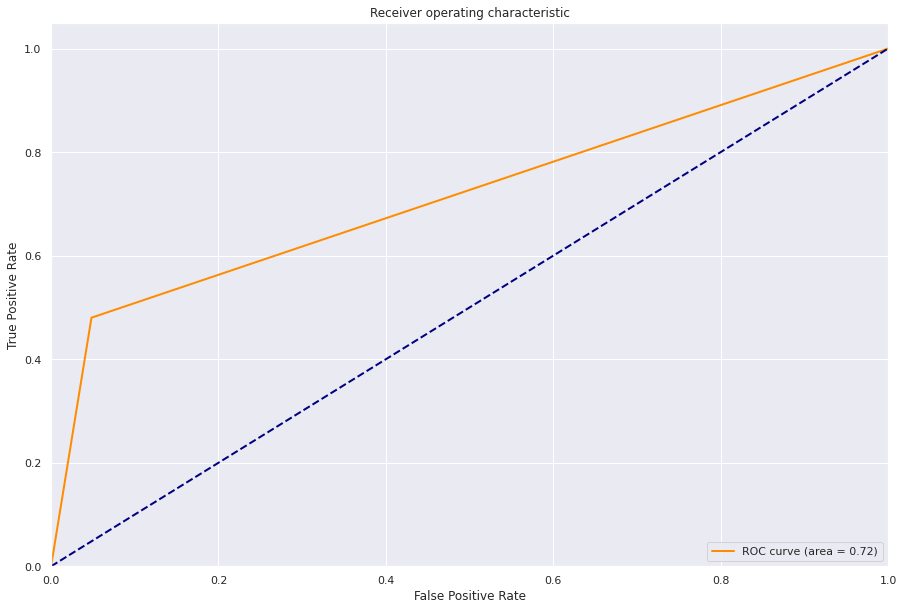

0.7159685850822909

In [9]:
fpr, tpr, thresholds = roc_curve(y_to_validate_valdev, red7.predict(x_val_normalizado_abs).round())
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_to_validate_valdev, red7.predict(x_val_normalizado_abs).round()))

Observamos un performance muy levemente inferior a la red sin regularizar.

Finalmente nos quedamos con el modelo que mejor puntaje AUC-Score obtuvo, que es la quinta red. Medimos todas sus metricas

### Matriz de confusión



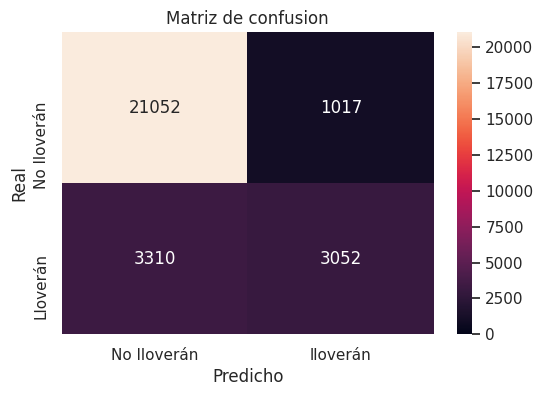

In [11]:
predicciones = red5.predict(x_val_normalizado_abs).round()
plot_confusion_matrix(y_to_validate_valdev, predicciones)

#### Accuracy

In [12]:
accuracy_score_got = accuracy_score(y_to_validate_valdev,predicciones)
print("ACCURACY SCORE: ",accuracy_score_got)

ACCURACY SCORE:  0.8478069712637614


#### Precision y Recall 



In [13]:
precision = precision_score(y_to_validate_valdev,predicciones)
recall = recall_score(y_to_validate_valdev,predicciones)

print("PRECISION: ",precision,"\nRECALL: ",recall)

PRECISION:  0.7500614401572868 
RECALL:  0.47972335743476896


#### F1 Score

In [15]:
f1_score_got = f1_score(y_to_validate_valdev, predicciones)
print("F1 SCORE: ", f1_score_got)

F1 SCORE:  0.5851787939794842


Tiene un accuracy peor al obtenido en el TP1. Analizando su AUC score este modelo es mucho peor al resto de los entrenados.
* Del total de dias que lloverán en el dataset(6362), logró prededir a 3052 de ellos(menos de la mitad)
* Del total de dias que no lloverán en el dataset(22069), logró prededir a 21052 de ellos(mucho más de la mitad)
* Del total de predichos como que lloverán (4069), en 3052 de ellos realmente iba a llover al dia siguiente.

## Predicción sobre el nuevo dataset

Realizamos la predicción sobre el nuevo dataset utilizando el preprocesamiento de transformar todas las variables a numericas.

In [16]:
nuevo_ds = obtener_prediccion_set()
ids_registro = np.array(nuevo_ds['id'])

nuevo_ds = aplicarOneHot(nuevo_ds)
nuevo_ds.drop('id', inplace=True, axis=1)
pca_ds, componentes_principales_nds = aplicarPCA(x, nuevo_ds, 7)
nuevo_ds_normalizado = normalizar_segun_maximo_valor_absoluto(componentes_principales, componentes_principales_nds)

predicciones = red5.predict(nuevo_ds_normalizado)
predicciones

array([[0.05231327],
       [0.01966679],
       [0.3206421 ],
       ...,
       [0.08258307],
       [0.15560764],
       [0.20141762]], dtype=float32)

In [17]:
predicciones = predicciones.round()
predicciones

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [18]:
def transformar(e):
    if e == 0:
        return "no"
    return "si"

vfunc = np.vectorize(transformar)

result = vfunc(predicciones)
prediccion_final = []
for element in result:
    prediccion_final.append(element[0])
crear_archivo_predicciones(prediccion_final,"Red Neuronal",ids_registro)